In [2]:
import os
import sys

import pandas as pd

from utilities.load_utils import *
from utilities.path_utils import *
from utilities.model_utils import *
from utilities.files_utils import *
from models.train_model import *
from utilities.constants import *

In [3]:
data_name = 'netrisk_casco_v36'
train_data_name = 'netrisk_casco_v36'
target_variable = 'ALFA_price'
pred = f'{target_variable}_pred'
data, features = load_data(get_processed_data_path(data_name), get_features_path(data_name), target_variable)

In [4]:
model = load_model(get_model_path(get_model_name(train_data_name, target_variable)))

In [30]:
importances = pd.Series(model.get_score(importance_type = 'cover'), name = 'feature').reset_index()
importances['feature_original'] = importances['index'].apply(lambda x : x.split('__')[0])  

In [31]:
importances.groupby('feature_original')['feature'].sum()

feature_original
ALFA_price_Age_cut           7.706299e+03
ALFA_price_PostalCode_cut    5.884545e+03
Age                          1.306074e+03
BonusMalus                   6.255043e+04
BonusMalusCode               4.529592e+02
CarAge                       8.264999e+02
CarMake                      3.237988e+05
CarMakerCategory             3.453426e+03
CarModel                     3.248793e+06
Category                     4.942589e+02
Latitude                     1.944867e+03
Longitude                    1.724166e+03
PostalCode                   1.201825e+03
PostalCode2                  7.833541e+03
PostalCode3                  6.329361e+03
car_value                    1.989623e+03
ccm                          3.088552e+03
isRecent                     5.161104e+03
kg                           2.391066e+03
kw                           5.899590e+03
Name: feature, dtype: float64

<Axes: ylabel='feature_original'>

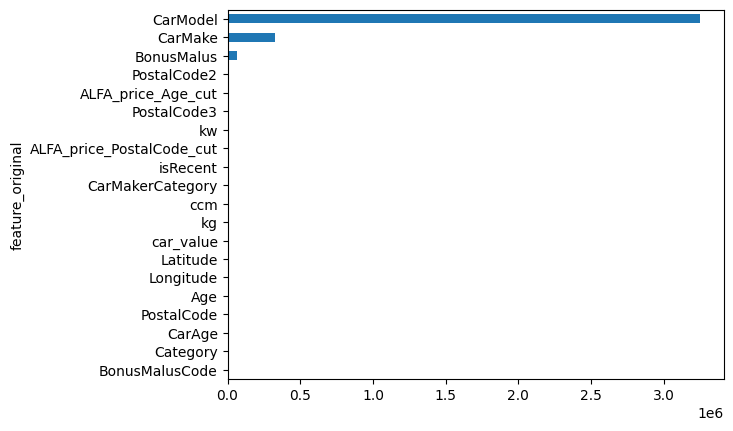

In [32]:
importances.groupby('feature_original')['feature'].sum().sort_values().plot(kind = 'barh')

In [44]:
data[pred] = predict(model, data[features])

In [45]:
data['error'] = abs(data[target_variable] - data[pred])

In [46]:
data['error'].mean()

934.1354251113085

In [41]:
data

,DateCrawled,isRecent,CarMake,CarModel,CarAge,ccm,kw,kg,car_value,CarMakerCategory,...,Longitude,Latitude,Age,LicenseAge,BonusMalus,BonusMalusCode,GROUPAMA_price_Age_cut,GROUPAMA_price,GROUPAMA_price_pred,error
0,2024_07_03,True,47,101,6,999,66,1199,12766.000,1.00,...,19.9248,47.2748,47,18,4.0,5,5.0,135564.0,171554.687500,35990.687500
1,2024_07_03,True,58,276,2,1498,110,1470,28756.884,1.00,...,21.6333,47.5333,60,18,6.0,7,7.0,252576.0,188605.703125,63970.296875
2,2024_07_03,True,20,64,5,1499,110,1394,15886.000,1.00,...,20.1482,46.2530,52,18,1.0,2,6.0,135036.0,350506.375000,215470.375000
3,2024_07_03,True,5,0,4,1499,100,1365,17063.800,1.00,...,18.3057,45.7895,45,18,6.0,7,4.0,235824.0,225932.421875,9891.578125
4,2024_07_03,True,52,96,3,898,56,1090,9747.400,1.00,...,19.0404,47.4984,42,18,0.0,1,4.0,104832.0,318605.468750,213773.468750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1816,2024_07_03,True,5,3,5,1499,103,1385,23871.640,1.00,...,16.6216,47.2309,31,18,7.0,8,2.0,249276.0,218321.984375,30954.015625
1817,2024_07_03,True,47,101,4,1199,74,1165,15730.000,1.00,...,19.0404,47.4984,65,18,3.0,4,8.0,144192.0,171921.031250,27729.031250
1818,2024_07_03,True,20,151,4,1498,121,1885,25727.000,1.00,...,19.0404,47.4984,50,18,0.0,1,5.0,391524.0,394929.250000,3405.250000
1819,2024_07_03,True,12,170,2,999,74,1223,17885.400,0.97,...,18.2333,46.0833,34,18,0.0,1,2.0,132024.0,135208.750000,3184.750000


In [2]:
data = pd.read_csv(get_processed_data_path('signal_casco'))
def cut_brackets_numeric(values : pd.Series, brackets : list) -> pd.Series:

    bins = [interval[0] - 1 for interval in brackets] + [brackets[-1][1]]
    return pd.cut(values, bins = bins)

def cut_brackets_categorical(values : pd.Series, brackets : list) -> pd.Series:
    return values


import json
def add_bracket_features(data : pd.DataFrame, target_variables : list, feature : str) -> pd.DataFrame:
    brackets_path = get_brackets_path(feature)
    if not os.path.exists(brackets_path):
        return data
    print(brackets_path)
    with open(brackets_path, 'r') as json_file:
        brackets = json.load(json_file)

    if pd.api.types.is_numeric_dtype(data[feature]):
        cut_function = lambda x, y : cut_brackets_numeric(x, y)
    else:
        cut_function = lambda x, y : cut_brackets_categorical(x, y)

    for target_variable in target_variables:
        target_variable = 'WÁBERER_price' if target_variable == 'GRÁNIT_price' else target_variable
        if len(brackets[target_variable]) == 0:
            continue
        cut_name = f'{target_variable}_{feature}_cut'
        data[cut_name] = cut_function(data[feature], brackets[target_variable])

    return data

target_variables = ['K&AMP;H_price', 'ALFA_price', 'SIGNAL_price', 'KÖBE_price', 'GROUPAMA_price', 'UNIQA_price', 'GENERALI_price', 'ALLIANZ_price', 'MAGYAR_price']
data = add_bracket_features(data, target_variables, 'Age')
data.to_csv(get_processed_data_path('signal_casco'), index = False)

../data/external/feature_brackets/Age_brackets.json


In [3]:
data

,Unnamed: 0,policyNr,isRecent,CarMake,CarAge,ccm,kw,kg,car_value,CarMakerCategory,...,BonusMalusCode,K&AMP;H_price_Age_cut,ALFA_price_Age_cut,SIGNAL_price_Age_cut,KÖBE_price_Age_cut,GROUPAMA_price_Age_cut,UNIQA_price_Age_cut,GENERALI_price_Age_cut,ALLIANZ_price_Age_cut,MAGYAR_price_Age_cut
0,0,83000000022,True,TOYOTA,16,1998,93.0,1575,15392.000,1,...,3,"(60.0, 65.0]","(34.0, 79.0]","(34.0, 79.0]","(50.0, 79.0]","(60.0, 65.0]","(62.0, 64.0]","(39.0, 69.0]","(59.0, 69.0]","(49.0, 65.0]"
1,1,83000116893,True,TOYOTA,16,1998,93.0,1575,15392.000,1,...,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,83000000063,True,RENAULT,15,1149,74.0,1120,7930.000,1,...,2,"(60.0, 65.0]","(34.0, 79.0]","(34.0, 79.0]","(50.0, 79.0]","(60.0, 65.0]","(61.0, 62.0]","(39.0, 69.0]","(59.0, 69.0]","(49.0, 65.0]"
3,3,83000078499,True,RENAULT,15,1149,74.0,1120,7930.000,1,...,2,"(45.0, 50.0]","(34.0, 79.0]","(34.0, 79.0]","(35.0, 50.0]","(45.0, 50.0]","(47.0, 48.0]","(39.0, 69.0]","(43.0, 59.0]","(29.0, 49.0]"
4,4,83003081649,True,RENAULT,15,1149,74.0,1120,7930.000,1,...,4,"(50.0, 55.0]","(34.0, 79.0]","(34.0, 79.0]","(50.0, 79.0]","(50.0, 55.0]","(50.0, 53.0]","(39.0, 69.0]","(43.0, 59.0]","(49.0, 65.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23200,23200,83024078293,True,VOLKSWAGEN,6,1968,110.0,1598,25548.562,1,...,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23201,23201,83026871497,True,VOLKSWAGEN,11,1968,103.0,1276,24964.108,1,...,4,"(35.0, 45.0]","(34.0, 79.0]","(34.0, 79.0]","(35.0, 50.0]","(40.0, 45.0]","(43.0, 44.0]","(39.0, 69.0]","(43.0, 59.0]","(29.0, 49.0]"
23202,23202,83027999966,True,RENAULT,9,1461,66.0,1121,12298.000,1,...,2,"(45.0, 50.0]","(34.0, 79.0]","(34.0, 79.0]","(35.0, 50.0]","(45.0, 50.0]","(49.0, 50.0]","(39.0, 69.0]","(43.0, 59.0]","(49.0, 65.0]"
23203,23203,83033999950,True,RENAULT,10,1461,66.0,1381,12298.000,1,...,7,"(70.0, 79.0]","(34.0, 79.0]","(34.0, 79.0]","(50.0, 79.0]","(70.0, 79.0]","(70.0, 71.0]","(69.0, 77.0]","(69.0, 72.0]","(65.0, 79.0]"


In [2]:
service = 'netrisk_casco'
dates = '2023_11_14__2023_11_20__2023_12_12__2023_12_22__2023_12_28__2023_12_29__2024_01_02'.split('__')
cur = ''
dates_pref = []

for i in range(1, len(dates)):
    dates_pref.append("__".join(dates[ : i + 1]))


In [3]:
dates_pref

['2023_11_14__2023_11_20',
 '2023_11_14__2023_11_20__2023_12_12',
 '2023_11_14__2023_11_20__2023_12_12__2023_12_22',
 '2023_11_14__2023_11_20__2023_12_12__2023_12_22__2023_12_28',
 '2023_11_14__2023_11_20__2023_12_12__2023_12_22__2023_12_28__2023_12_29',
 '2023_11_14__2023_11_20__2023_12_12__2023_12_22__2023_12_28__2023_12_29__2024_01_02']

In [7]:
service = 'netrisk_casco'
data_name_benchmark = 'netrisk_casco_benchmark_v1'
target_variable = 'KÖBE_price'
#target_variable = 'ALFA_price'

dates_pref = []
data_names = [f'{service}_{date}' for date in dates_pref]
data_names += ['netrisk_casco_v10', 'netrisk_casco_v14', 'netrisk_casco_v15', 'netrisk_casco_v16', 'netrisk_casco_v17']
model_names = [get_model_name(data_name, target_variable) for data_name in data_names]

data_path_benchmark = get_processed_data_path(data_name_benchmark)
features_path_benchmark = get_features_path(data_name_benchmark)
model_paths = [get_model_path(model_name) for model_name in model_names]


data_benchmark, features = load_data(data_path_benchmark, features_path_benchmark, target_variable)

print(data_benchmark.head())

models = [None] * len(model_paths)
for i in range(len(model_paths)):
    model = None
    try:
        model = load_model(model_paths[i])
    except Exception as e:
        print(model_paths[i])
        data, features = load_data(get_processed_data_path(data_names[i]), get_features_path(data_names[i]), target_variable)
        tm.train_model_util(data, features, target_variable, is_classification = False)
        model = load_model(model_paths[i])
    models[i] = model
        
models = [load_model(model_path) for model_path in model_paths]

print(data_benchmark)

predictions = [predict(model, data_benchmark[features]) for model in models]

errors = [mean_absolute_error(prediction, data_benchmark[target_variable]) for prediction in predictions]

target_error = data_benchmark[target_variable].mean() * 0.03

  DateCrawled  isRecent  CarMake  CarAge   ccm  kw    kg  car_value  \
0  2024_01_04      True        1       2   999  74  1180    14534.0   
1  2024_01_04      True        1       4   999  92  1322    22295.0   
2  2024_01_04      True        1       1   998  49   899    14687.4   
3  2024_01_04      True        1       4  1318  75  1093    11541.4   
4  2024_01_04      True        1       5   898  66  1082     9747.4   

   CarMakerCategory  PostalCode  PostalCode2  PostalCode3  Category  \
0               1.0        7391           73          739         2   
1               1.0        1038           10          103         2   
2               1.0        7762           77          776         3   
3               1.0        5630           56          563         1   
4               1.0        8447           84          844         7   

   Longitude  Latitude  Age  LicenseAge  BonusMalus  BonusMalusCode  \
0    18.0809   46.1993   52          18         0.0               1   
1   

KeyboardInterrupt: 

In [4]:
predictions[0]

array([144431.64 , 208414.28 , 117936.41 , 115987.42 ,  69173.48 ,
       210662.83 , 175557.22 , 240424.28 , 110757.63 ,  70270.32 ,
       312573.97 , 365181.6  , 160850.56 , 129522.945, 124212.06 ,
       148967.08 , 268392.44 , 194488.77 , 396393.97 , 139286.78 ,
       112734.26 ,  54787.64 ,  86339.06 , 118800.9  , 166872.03 ,
       187617.7  , 101695.01 ,  52053.375, 225118.58 , 133657.22 ,
       125439.49 , 157130.22 ,  85441.41 , 154875.64 , 114672.89 ,
        50510.83 , 158659.2  , 166566.14 ,  88084.86 ,  68947.85 ,
       128945.79 , 140480.1  , 163002.19 , 444309.78 , 133082.45 ,
        61681.46 , 138312.02 , 143362.44 , 151429.02 ,  97302.4  ,
       126179.96 , 130821.07 , 127556.13 ,  85375.65 ,  95471.125,
       107977.766,  89297.62 ,  53124.684, 166677.97 , 128838.445,
       163856.5  ,  54147.63 ,  75256.29 , 132041.61 , 117002.05 ,
       121248.766, 190890.62 , 147827.64 , 128193.33 ,  81891.805,
        89248.016, 147343.5  ,  61454.21 , 181954.33 , 169129.

In [5]:
predictions[-1]

array([147452.89 , 208767.77 , 116571.07 , 114578.59 ,  66532.086,
       203921.06 , 190406.81 , 263591.53 , 100913.83 ,  68512.984,
       393950.1  , 341117.8  , 161259.28 , 117148.41 , 124106.81 ,
       171825.31 , 298252.1  , 197478.83 , 400343.6  , 145296.03 ,
       110075.164,  53346.37 ,  88470.99 , 117915.305, 162383.3  ,
       223607.31 , 105375.34 ,  48259.312, 222349.28 , 132149.06 ,
       116167.46 , 184940.03 ,  83484.65 , 159669.62 , 112902.266,
        48016.65 , 157733.23 , 156990.1  ,  83329.46 ,  70338.586,
       120517.164, 133160.2  , 159753.75 , 379036.03 , 135580.38 ,
        61980.777, 126102.23 , 137715.78 , 135688.12 , 100043.86 ,
       125877.42 , 142833.69 , 133783.78 ,  76335.016,  91671.89 ,
       103831.77 ,  77079.46 ,  52796.723, 165666.36 , 124418.125,
       165120.27 ,  55315.84 ,  76390.914, 122499.65 , 125922.42 ,
       125554.04 , 185012.2  , 141803.88 , 151936.1  ,  79144.34 ,
        82371.34 , 148458.72 ,  58686.195, 193153.6  , 148776.

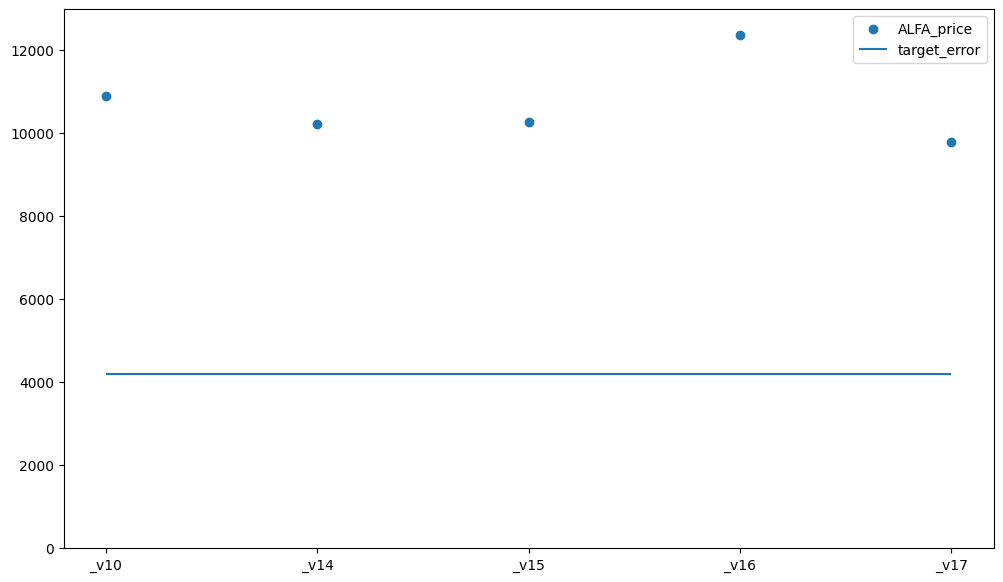

In [6]:
plt.figure(figsize = (12, 7))
x_labels = [c.replace(service, '').split('__')[-1] for c in data_names]
plt.scatter(x_labels, errors, label = target_variable)
top = max(target_error, max(errors))  * 1.05
plt.ylim(bottom = 0, top = top)
plt.hlines(y = data_benchmark[target_variable].mean() * 0.03, xmin = x_labels[0], xmax = x_labels[-1], label = 'target_error')
plt.legend()
plt.show()

In [8]:
np.array(errors) / data_benchmark[target_variable].mean() * 100

array([6.94998462])

In [30]:
data_benchmark[target_variable].mean() * 0.03

4199.426121372031

In [32]:
data, features = load_data(get_processed_data_path("netrisk_casco_v3"), get_features_path("netrisk_casco_v3"), target_variable = target_variable)

In [38]:
data[target_variable].nunique()

379

In [44]:
def plotHistErrorPercenage(error : np.array) -> None:
    plt.hist(error, range = [error.min() - 1, error.max() + 1], bins=40,
             weights=np.ones(len(error)) / len(error))
    plt.xlabel('Error percentage')
    plt.ylabel('Percent of errors')
    plt.show()


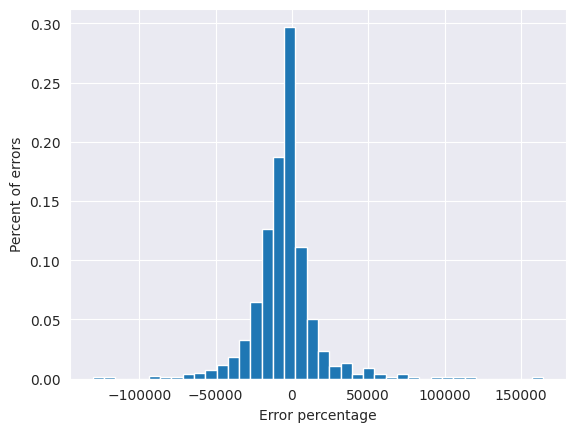

In [18]:
plotHistErrorPercenage(data_benchmark[target_variable] - predictions[-1])

In [ ]:
percentage_error.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 1])

In [ ]:
data[target_variable]

In [ ]:
data[data[target_variable] == 54900]

In [ ]:
data[(data['BonusMalus'] == 0) & (data['Age'].between(30, 40)) & (data['PostalCode'] < 2000)][['car_value', target_variable]].plot(kind = 'scatter', x = 'car_value', y = target_variable)

In [ ]:
data.plot(kind = 'scatter', x = 'car_value', y = target_variable)

In [ ]:
data.groupby(['car_value', 'Category', 'Age'])[target_variable].agg([('range', np.ptp), ('count', 'count'), ('min', 'min'), ('max', 'max'), ('minidx', 'idxmin'), ('maxidx', 'idxmax')])

In [ ]:
data.loc[[2923,2469]]

In [ ]:
1141680.0 / 574200.0


In [ ]:
gb_res = data.groupby(['Category', 'Age', 'kw', 'ccm', 'BonusMalus'])['car_value'].agg([('car_value_range', np.ptp), ('count', 'count'), ('idxmin', 'idxmin'), ('idxmax', 'idxmax')])

In [ ]:
def check(row):
    if row['idxmin'] == row['idxmax']:
        return 10
    try:
        min_row = data.loc[row['idxmin']]
        max_row = data.loc[row['idxmax']]
    
        price_ratio = max_row[target_variable] / min_row[target_variable]
        car_value_ratio = max_row['car_value'] / min_row['car_value']
        return abs(price_ratio - car_value_ratio)
    except Exception as e:
        return 100

In [ ]:
gb_res.apply(lambda x : check(x), axis = 1)

In [69]:
gb_res[gb_res['Catgory'] == 2]

KeyError: 'Catgory'

In [13]:
data_name = 'netrisk_casco_v17'
competitors = ["ALFA_price","ALLIANZ_price","GENERALI_price","GROUPAMA_price","K&AMP;H_price","KÖBE_price","UNIQA_price","WÁBERER_price"]
model_names = [get_model_name(data_name, target_variable) for target_variable in competitors]
out_of_sample_paths = [get_model_cv_out_of_sample_predictions_path(model_name) for model_name in model_names]
out_of_sample_preds = [pd.read_csv(out_of_sample_path) for out_of_sample_path in out_of_sample_paths]

data_path = get_processed_data_path(data_name)
data = pd.read_csv(data_path)

for model_name, preds in zip(model_names, out_of_sample_preds):
    data['model_name'] = preds.values


ValueError: Length of values (13698) does not match length of index (14248)

In [46]:
service = 'netrisk_casco'
target_variable = 'SIGNAL_price'

data_train_name = 'netrisk_casco_v29'
data_name_benchmark = 'netrisk_casco_benchmark_v1'
model_v = 'v29'
model_name = get_model_name(data_train_name, target_variable)

data_path_benchmark = get_processed_data_path(data_name_benchmark)
features_path_benchmark = get_features_path(data_name_benchmark)
model_path = get_model_path(model_name)

data, features = load_data(data_path_benchmark, features_path_benchmark, target_variable = target_variable, apply_feature_dtypes=True)
model = load_model(model_path)

model_features = pmx.get_expected_features(model)

isRecent bool
CarMake category
CarAge int64
ccm int64
kw int64
kg int64
car_value float64
CarMakerCategory float64
PostalCode int64
PostalCode2 int64
PostalCode3 int64
Category float64
Longitude float64
Latitude float64
Age int64
LicenseAge int64
BonusMalus category
BonusMalusCode int64
ALFA_postal_category int64
ALLIANZ_postal_category int64
GENERALI_postal_category int64
GENERTEL_postal_category int64
GROUPAMA_postal_category int64
K&AMP;H_postal_category int64
KÖBE_postal_category int64
MAGYAR_postal_category int64
SIGNAL_postal_category int64
UNION_postal_category int64
UNIQA_postal_category int64
WÁBERER_postal_category int64
Laoding ddata
['isRecent', 'CarMake', 'CarAge', 'ccm', 'kw', 'kg', 'car_value', 'CarMakerCategory', 'PostalCode', 'PostalCode2', 'PostalCode3', 'Category', 'Longitude', 'Latitude', 'Age', 'LicenseAge', 'BonusMalus', 'BonusMalusCode', 'ALFA_postal_category', 'ALLIANZ_postal_category', 'GENERALI_postal_category', 'GENERTEL_postal_category', 'GROUPAMA_postal_cat

In [47]:
data = mpd.make_processed_generator_data(data)

../data/external/feature_brackets/Age_brackets.json
../data/external/mtpl_postal_categories/aegon_lookups_table.csv
../data/external/mtpl_postal_categories/allianz_lookups_table.csv
../data/external/mtpl_postal_categories/generali_lookups_table.csv
../data/external/mtpl_postal_categories/genertel_lookups_table.csv
../data/external/mtpl_postal_categories/groupama_lookups_table.csv
../data/external/mtpl_postal_categories/kh_lookups_table.csv
../data/external/mtpl_postal_categories/aegon_lookups_table.csv
../data/external/mtpl_postal_categories/magyar_lookups_table.csv
../data/external/mtpl_postal_categories/si_lookups_table.csv
../data/external/mtpl_postal_categories/union_lookups_table.csv
../data/external/mtpl_postal_categories/uniqa_lookups_table.csv
../data/external/mtpl_postal_categories/waberer_lookups_table.csv
DateCrawled                   object
isRecent                        bool
CarMake                     category
CarAge                         int64
ccm                     

In [48]:
data

,DateCrawled,isRecent,CarMake,CarAge,ccm,kw,kg,car_value,CarMakerCategory,PostalCode,...,GENERALI_postal_category,GENERTEL_postal_category,GROUPAMA_postal_category,K&AMP;H_postal_category,KÖBE_postal_category,MAGYAR_postal_category,SIGNAL_postal_category,UNION_postal_category,UNIQA_postal_category,WÁBERER_postal_category
0,2024_01_04,True,1,2,999,74,1180,14534.000,1.00,7391,...,39.0,42.0,10,4.0,2,7.0,3.0,3,3.0,11.0
1,2024_01_04,True,1,4,1318,75,1093,11541.400,1.00,5630,...,65.0,65.0,13,8.0,1,7.0,4.0,5,1.0,11.0
2,2024_01_04,True,1,7,1199,60,980,9477.000,1.00,1078,...,80.0,84.0,2,1.0,1,2.0,1.0,2,9.0,2.0
3,2024_01_04,True,1,7,1496,66,1000,13249.340,1.00,2211,...,97.0,117.0,7,5.0,2,3.0,4.0,7,2.0,7.0
4,2024_01_04,True,1,6,1199,50,1055,9620.000,1.00,4566,...,65.0,117.0,13,6.0,7,7.0,4.0,9,1.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,2024_01_04,True,1,2,999,67,1182,17287.400,1.00,2094,...,113.0,117.0,4,3.0,2,2.0,3.0,2,4.0,2.0
415,2024_01_04,True,1,8,1329,73,1245,14768.000,0.97,1085,...,78.0,82.0,3,1.0,1,7.0,1.0,1,9.0,1.0
416,2024_01_04,True,1,3,988,93,1275,17807.400,1.00,2463,...,19.0,117.0,10,5.0,4,7.0,4.0,8,3.0,8.0
417,2024_01_04,True,1,10,999,85,1081,13195.000,1.00,8137,...,8.0,8.0,14,5.0,7,7.0,2.0,10,2.0,10.0


In [49]:
pmx.is_compatible(model, data)

['isRecent', 'CarMake', 'CarAge', 'ccm', 'kw', 'kg', 'car_value', 'CarMakerCategory', 'PostalCode', 'PostalCode2', 'PostalCode3', 'Category', 'Longitude', 'Latitude', 'Age', 'LicenseAge', 'BonusMalus', 'BonusMalusCode', 'SIGNAL_price_Age_cut']
set()


True

In [50]:
min(predict(model, data[pmx.get_expected_features(model)]))

67123.94

In [51]:
data[target_variable]

0      210734.0
1      184150.0
2      230648.0
3       95875.0
4       82030.0
         ...   
414    205690.0
415    209793.0
416    170787.0
417    113922.0
418    107477.0
Name: SIGNAL_price, Length: 419, dtype: float64

In [52]:
data[target_variable + '_predicted'] = predict(model, data[model_features])

In [53]:
data['error'] = data[target_variable] - data[target_variable + '_predicted']
data['abs_error'] = abs(data[target_variable] - data[target_variable + '_predicted'])

In [54]:
data[[target_variable, target_variable + '_predicted', 'error', 'abs_error']]

,SIGNAL_price,SIGNAL_price_predicted,error,abs_error
0,210734.0,207836.781250,2897.218750,2897.218750
1,184150.0,194983.671875,-10833.671875,10833.671875
2,230648.0,210593.843750,20054.156250,20054.156250
3,95875.0,79416.664062,16458.335938,16458.335938
4,82030.0,81030.617188,999.382812,999.382812
...,...,...,...,...
414,205690.0,209543.765625,-3853.765625,3853.765625
415,209793.0,217101.203125,-7308.203125,7308.203125
416,170787.0,180489.875000,-9702.875000,9702.875000
417,113922.0,116724.671875,-2802.671875,2802.671875


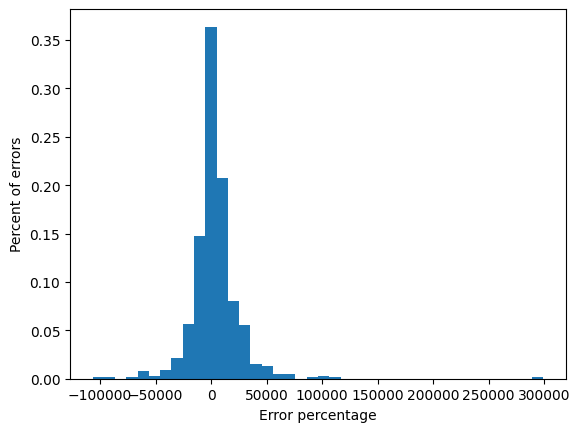

In [45]:
plotHistErrorPercenage(data['error'])

In [56]:
data

,DateCrawled,isRecent,CarMake,CarAge,ccm,kw,kg,car_value,CarMakerCategory,PostalCode,...,K&AMP;H_postal_category,KÖBE_postal_category,MAGYAR_postal_category,SIGNAL_postal_category,UNION_postal_category,UNIQA_postal_category,WÁBERER_postal_category,SIGNAL_price_predicted,error,abs_error
0,2024_01_04,True,1,2,999,74,1180,14534.000,1.00,7391,...,4.0,2,7.0,3.0,3,3.0,11.0,207836.781250,2897.218750,2897.218750
1,2024_01_04,True,1,4,1318,75,1093,11541.400,1.00,5630,...,8.0,1,7.0,4.0,5,1.0,11.0,194983.671875,-10833.671875,10833.671875
2,2024_01_04,True,1,7,1199,60,980,9477.000,1.00,1078,...,1.0,1,2.0,1.0,2,9.0,2.0,210593.843750,20054.156250,20054.156250
3,2024_01_04,True,1,7,1496,66,1000,13249.340,1.00,2211,...,5.0,2,3.0,4.0,7,2.0,7.0,79416.664062,16458.335938,16458.335938
4,2024_01_04,True,1,6,1199,50,1055,9620.000,1.00,4566,...,6.0,7,7.0,4.0,9,1.0,10.0,81030.617188,999.382812,999.382812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,2024_01_04,True,1,2,999,67,1182,17287.400,1.00,2094,...,3.0,2,2.0,3.0,2,4.0,2.0,209543.765625,-3853.765625,3853.765625
415,2024_01_04,True,1,8,1329,73,1245,14768.000,0.97,1085,...,1.0,1,7.0,1.0,1,9.0,1.0,217101.203125,-7308.203125,7308.203125
416,2024_01_04,True,1,3,988,93,1275,17807.400,1.00,2463,...,5.0,4,7.0,4.0,8,3.0,8.0,180489.875000,-9702.875000,9702.875000
417,2024_01_04,True,1,10,999,85,1081,13195.000,1.00,8137,...,5.0,7,7.0,2.0,10,2.0,10.0,116724.671875,-2802.671875,2802.671875


In [2]:
# Make a better system naming things, with doucmentation
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
notebook_dir = os.path.abspath(os.getcwd())
src_path = os.path.join('/home/lerceg/LukaPosao/market_models/', 'src')
sys.path.append(src_path)

import market_models.src.models.predict_model as pmx
import market_models.src.models.train_model as tm
from market_models.src.utils import *
import market_models.src.data.make_processed_data as mpd

target_variable = 'ALFA_price'
target_prediction = 'ALFA_price_predicted'
target_error = 'ALFA_price_error'
data_name = 'netrisk_casco_v30'
model_name = 'netrisk_casco_v29'


data, features = load_data(get_processed_data_path(data_name), get_features_path(data_name), target_variable = 'ALFA_price')
model = load_model(get_model_path(get_model_name(model_name, target_variable)))

isRecent bool
CarMake category
CarModel object
CarAge int64
ccm int64
kw int64
kg int64
car_value float64
CarMakerCategory float64
PostalCode int64
PostalCode2 int64
PostalCode3 int64
Category float64
Longitude float64
Latitude float64
Age int64
LicenseAge int64
BonusMalus category
BonusMalusCode int64
ALFA_postal_category int64
ALLIANZ_postal_category int64
GENERALI_postal_category int64
GENERTEL_postal_category int64
GROUPAMA_postal_category int64
K&AMP;H_postal_category int64
KÖBE_postal_category int64
MAGYAR_postal_category int64
SIGNAL_postal_category int64
UNION_postal_category int64
UNIQA_postal_category int64
WÁBERER_postal_category int64
ALFA_price_Age_cut category
ALLIANZ_price_Age_cut category
GENERALI_price_Age_cut category
GROUPAMA_price_Age_cut category
K&AMP;H_price_Age_cut category
KÖBE_price_Age_cut category
MAGYAR_price_Age_cut category
SIGNAL_price_Age_cut category
UNIQA_price_Age_cut category
Laoding data
['isRecent', 'CarMake', 'CarModel', 'CarAge', 'ccm', 'kw', 'k

In [5]:
data[target_prediction] = predict(model, data[pmx.get_expected_features(model)])
data[target_error] = abs(data[target_prediction] - data[target_variable])

In [6]:
data

,DateCrawled,isRecent,CarMake,CarAge,ccm,kw,kg,car_value,CarMakerCategory,PostalCode,...,Longitude,Latitude,Age,LicenseAge,BonusMalus,BonusMalusCode,ALFA_price_Age_cut,ALFA_price,ALFA_price_predicted,ALFA_price_error
1,2024_01_02,True,28,2,998,49,899,15337.4,1.00,1011,...,19.0404,47.4984,35,18,0.0,1,3.0,175200.0,181572.812500,6372.812500
2,2024_01_02,True,66,1,1197,85,1390,25532.0,0.97,5200,...,20.4167,47.1833,35,18,0.0,1,3.0,167184.0,171884.609375,4700.609375
4,2024_01_02,True,5,2,1499,90,1545,30498.0,1.00,1011,...,19.0404,47.4984,35,18,0.0,1,3.0,400380.0,410889.656250,10509.656250
5,2024_01_02,True,66,1,1197,85,1390,25532.0,0.97,3770,...,20.7167,48.2167,35,18,0.0,1,3.0,167184.0,172509.093750,5325.093750
6,2024_01_02,True,66,1,1197,85,1390,25532.0,0.97,6791,...,20.1482,46.2530,35,18,0.0,1,3.0,203016.0,202020.656250,995.343750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15638,2024_06_06,True,66,4,1197,85,1390,19318.0,0.97,2899,...,18.2575,47.7033,36,18,6.0,7,3.0,179352.0,167785.265625,11566.734375
15639,2024_06_06,True,52,9,1149,54,1055,8424.0,1.00,8134,...,18.3478,46.9222,36,18,0.0,1,3.0,72108.0,66095.414062,6012.585938
15641,2024_06_06,True,21,9,1798,104,1266,16715.4,1.00,1144,...,19.0404,47.4984,54,18,0.0,1,3.0,176244.0,180715.531250,4471.531250
15642,2024_06_06,True,23,9,1591,130,1449,19757.4,0.97,2890,...,18.3184,47.6529,44,18,2.0,3,3.0,174012.0,169831.953125,4180.046875


In [71]:
import joblib
car_make_encoder = joblib.load(get_encoder_path('CarMake'))

In [76]:
for cl in car_make_encoder.classes_:
    print(cl, car_make_encoder.transform([cl]))

ALFA ROMEO [0]
ASIA [1]
ASTON MARTIN [2]
AUDI [3]
BENTLEY [4]
BMW [5]
CADILLAC [6]
CHEVROLET [7]
CHRYSLER [8]
CITROEN [9]
CORVETTE [10]
CUPRA [11]
DACIA [12]
DAEWOO [13]
DAIHATSU [14]
DFSK (DONGFENG) [15]
DODGE [16]
DS [17]
FERRARI [18]
FIAT [19]
FORD [20]
HONDA [21]
HUMMER [22]
HYUNDAI [23]
INFINITI [24]
ISUZU [25]
JAGUAR [26]
JEEP [27]
KIA [28]
LADA [29]
LANCIA [30]
LAND ROVER [31]
LEXUS [32]
LINCOLN [33]
LOTUS [34]
MAHINDRA [35]
MARUTI [36]
MASERATI [37]
MAZDA [38]
MERCEDES [39]
MERCEDES-BENZ [40]
MG [41]
MINI [42]
MITSUBISHI [43]
MOSZKVICS [44]
NISSAN [45]
OLTCIT [46]
OPEL [47]
PEUGEOT [48]
POLSKI FIAT [49]
PORSCHE [50]
PROTON [51]
RENAULT [52]
ROLLS-ROYCE [53]
ROVER [54]
SAAB [55]
SEAT [56]
SHUANGHUAN [57]
SKODA [58]
SMART [59]
SSANGYONG [60]
SUBARU [61]
SUZUKI [62]
TALBOT [63]
TATA [64]
TESLA [65]
TOYOTA [66]
TRABANT [67]
UAZ [68]
VOLGA [69]
VOLKSWAGEN [70]
VOLVO [71]
WARTBURG [72]
YUGO [73]
ZASTAVA [74]
ZAZ [75]


In [7]:
data

,DateCrawled,isRecent,CarMake,CarAge,ccm,kw,kg,car_value,CarMakerCategory,PostalCode,...,Longitude,Latitude,Age,LicenseAge,BonusMalus,BonusMalusCode,ALFA_price_Age_cut,ALFA_price,ALFA_price_predicted,ALFA_price_error
1,2024_01_02,True,28,2,998,49,899,15337.4,1.00,1011,...,19.0404,47.4984,35,18,0.0,1,3.0,175200.0,181572.812500,6372.812500
2,2024_01_02,True,66,1,1197,85,1390,25532.0,0.97,5200,...,20.4167,47.1833,35,18,0.0,1,3.0,167184.0,171884.609375,4700.609375
4,2024_01_02,True,5,2,1499,90,1545,30498.0,1.00,1011,...,19.0404,47.4984,35,18,0.0,1,3.0,400380.0,410889.656250,10509.656250
5,2024_01_02,True,66,1,1197,85,1390,25532.0,0.97,3770,...,20.7167,48.2167,35,18,0.0,1,3.0,167184.0,172509.093750,5325.093750
6,2024_01_02,True,66,1,1197,85,1390,25532.0,0.97,6791,...,20.1482,46.2530,35,18,0.0,1,3.0,203016.0,202020.656250,995.343750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15638,2024_06_06,True,66,4,1197,85,1390,19318.0,0.97,2899,...,18.2575,47.7033,36,18,6.0,7,3.0,179352.0,167785.265625,11566.734375
15639,2024_06_06,True,52,9,1149,54,1055,8424.0,1.00,8134,...,18.3478,46.9222,36,18,0.0,1,3.0,72108.0,66095.414062,6012.585938
15641,2024_06_06,True,21,9,1798,104,1266,16715.4,1.00,1144,...,19.0404,47.4984,54,18,0.0,1,3.0,176244.0,180715.531250,4471.531250
15642,2024_06_06,True,23,9,1591,130,1449,19757.4,0.97,2890,...,18.3184,47.6529,44,18,2.0,3,3.0,174012.0,169831.953125,4180.046875


In [1]:
data, features = load_data(get_processed_data_path('netrisk_casco_v29'), features_path = get_features_path('netrisk_casco_v29'))

NameError: name 'load_data' is not defined

In [2]:
data_name = 'nerisk_casco_v29'
data, features = load_data(get_processed_data_path(data_name), get_features_path(data_name), target_variable = 'ALFA_price')

NameError: name 'load_data' is not defined

In [3]:
data

NameError: name 'data' is not defined

In [ ]:
1